## Credit Card Fraud Final Project

### Introduction to problem and data

With the losses due to financial instrument fraud increasing from under 50 million dollars in 2015 to almost 250 million dollars in 2023 fraud identification algorithms are becoming more important than ever. There are too many fraud reports to follow each one manually in real time, and even when fraud is caught and reported financial transactions have become faster and faster, so it is often too late to reverse the damage.

Instead what is needed is preventative fraud detection that can stop a transaction before it happens, but that has it's own difficulties. With fraudsters constantly adapting to existing detection methods most traditional algorithms also cannot keep up as the manpower to keep updating them with new techniques is immense. Machine Learning is often used as a result, but ML approaches can be hampered by limited fraud data relative to the total number of transactions, which we will see in this project.

We want to experiment with the possibility of using an adversarial network to augment our fraud data. To prevent the adverarial network from collapsing we want to experiment with limiting the training of either the generator or the discriminator when one is already ahead of the other. We will also use a simple deep neural network as a baseline comparison for our adversarial model.

We will be working with the Kaggle credit card fraud dataset, which contains 284,807 rows of transactions, and 31 columns, including a Class column that indicates 0 if the transaction is legitimate and 1 if the transaction is not. Other than the time of the transaction and the amount of the transaction the remaining 28 columns are obfuscated as they may be too identifying for the column names to be released.

Github Repo: https://github.com/UweWei/Introduction-to-Deep-Learning

### Exploratory Data Analysis

We print some summary statistics of the data, and immediately notice that the dataset is already well cleaned with no null values to take care of, but that there are very few instances of fraud in the dataset. Only 492 elements in the 284,807 rows are fraud cases.

Additionally we construct overlaid KDE plots of each column, and can see that some columns have nearly identical plots for both fraud and non-fraud cases. This indicates that those columns are unlikely to provide much predictive power to our model, and plotting the correlation values in order of absolute value indicates that there are some near-0 correlations. While a Neural Network can usually disregard these fields on it's own, this project is working with limited compute resources, so we drop some of the least relevant columns to improve performance.

Finally we create a scaler and normalize the dataset, a technique that can prevent exploding or vanishing gradients that depend on the value of the input, and we generate a resampled dataset that duplicates the fraud data to a balanced level so that our models do not prefer to just assign fraud to all rows.

In [101]:
import keras
import pandas as pd
from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import keras_tuner
from sklearn.metrics import classification_report
import json

In [2]:
os.getcwd()
notebook_path = os.path.abspath("CreditCardFraud.ipynb")
data_labels_path = os.path.join(os.path.dirname(notebook_path), "RawImports/creditcard.csv")
data = pd.read_csv(data_labels_path)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


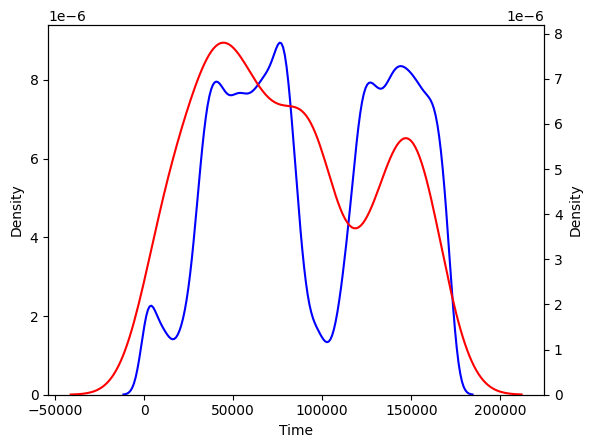

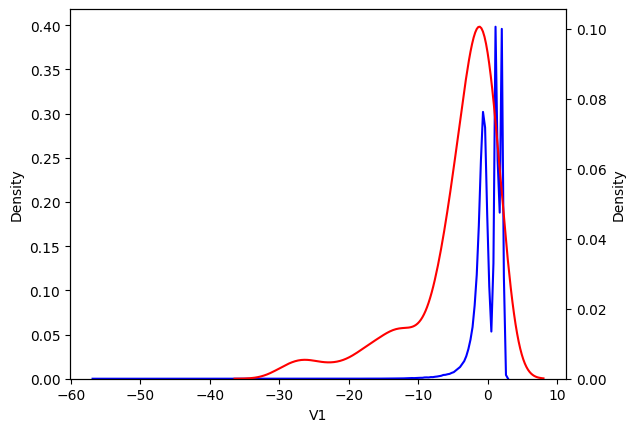

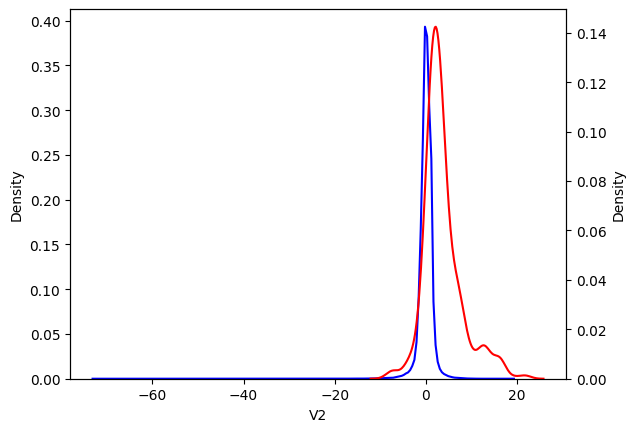

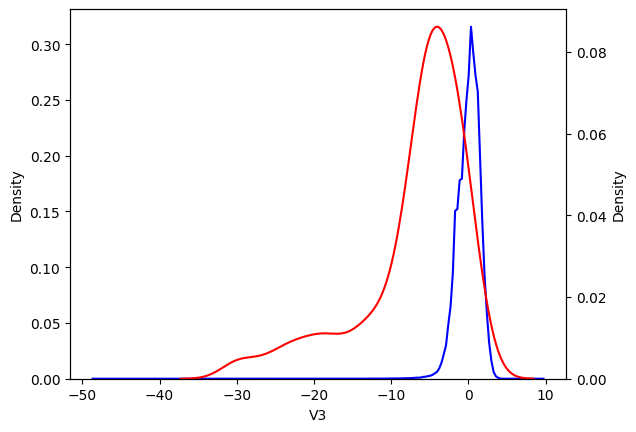

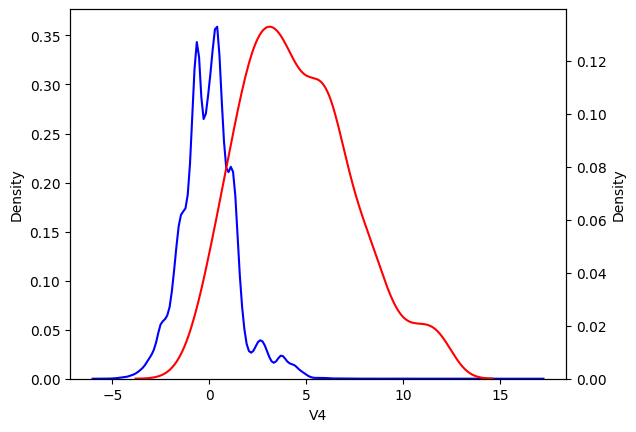

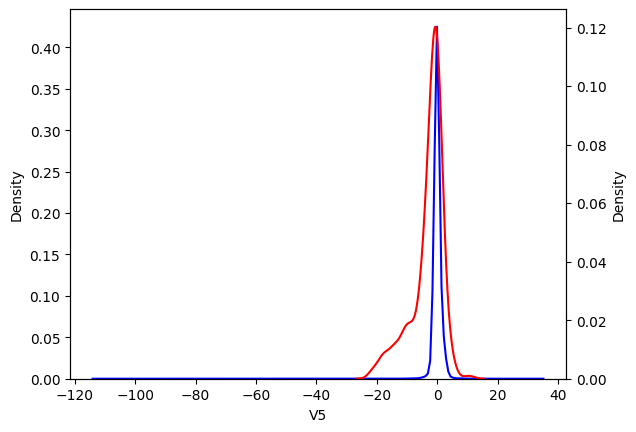

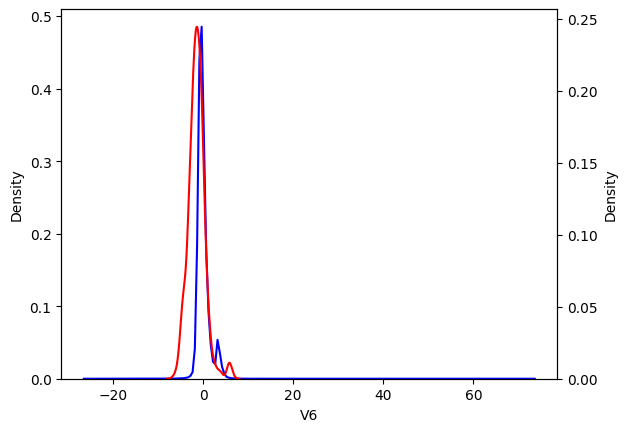

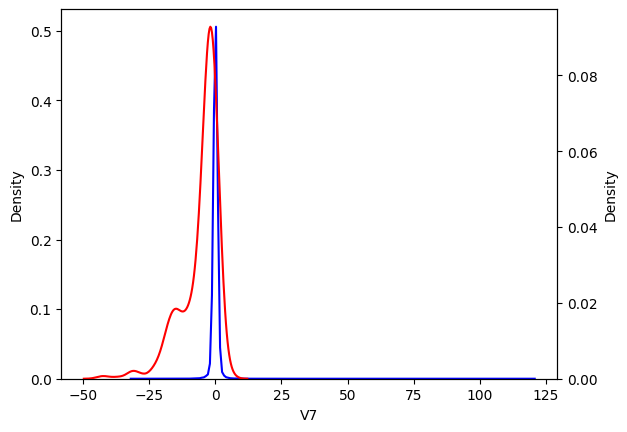

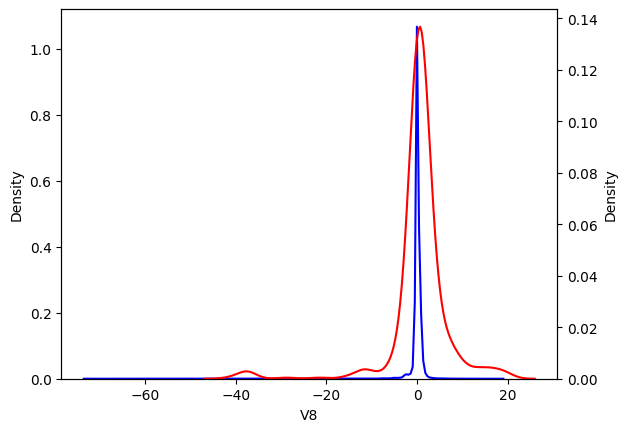

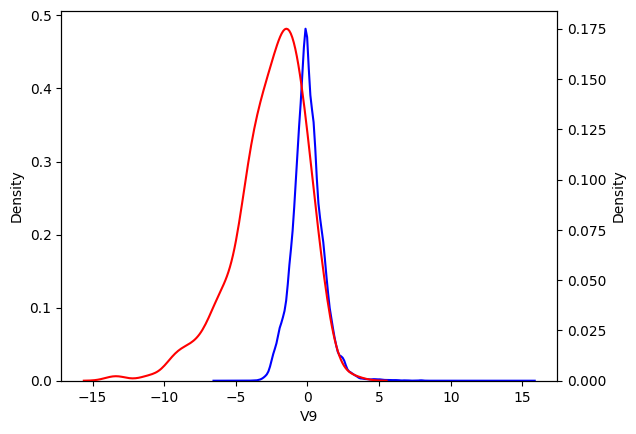

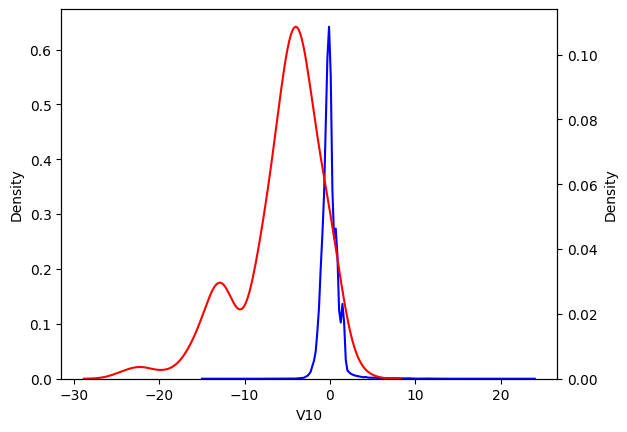

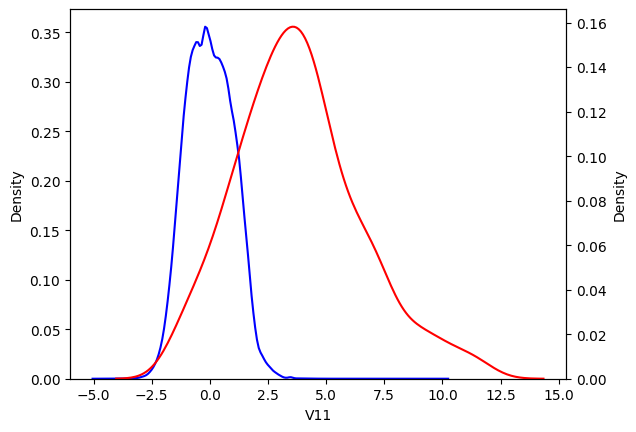

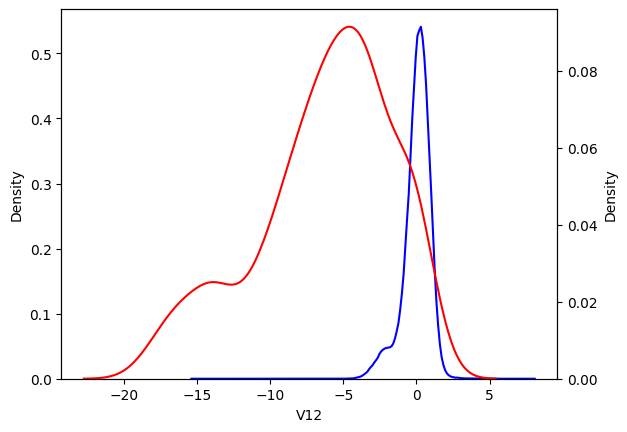

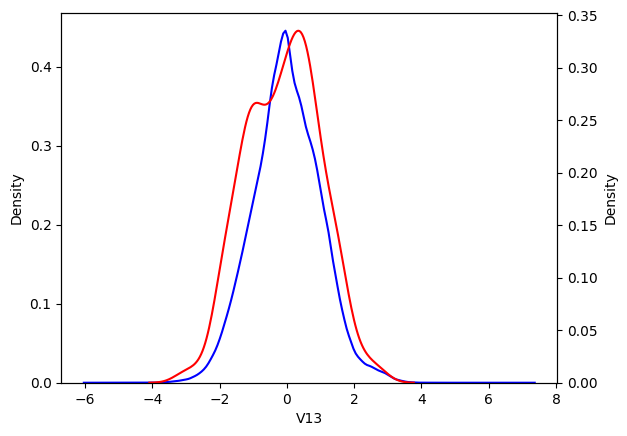

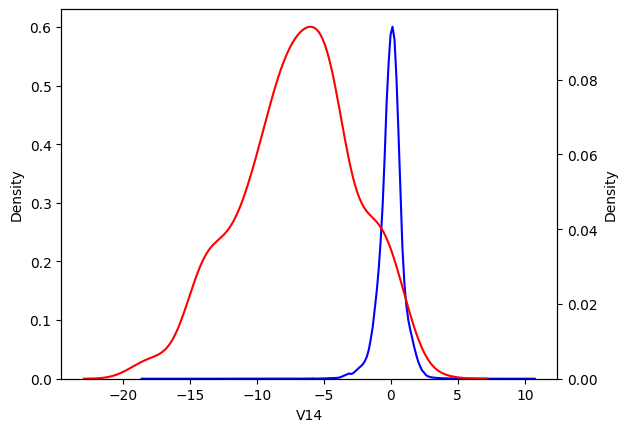

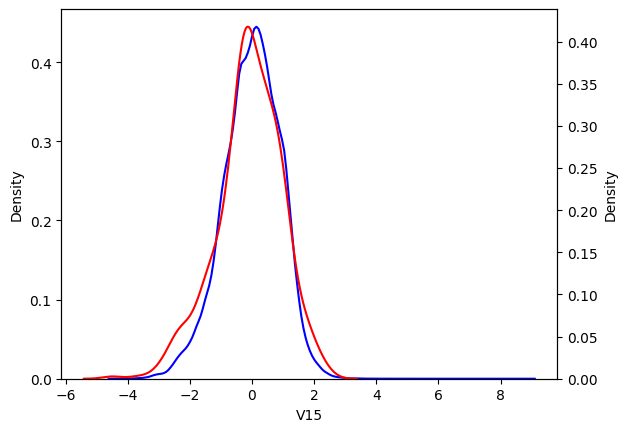

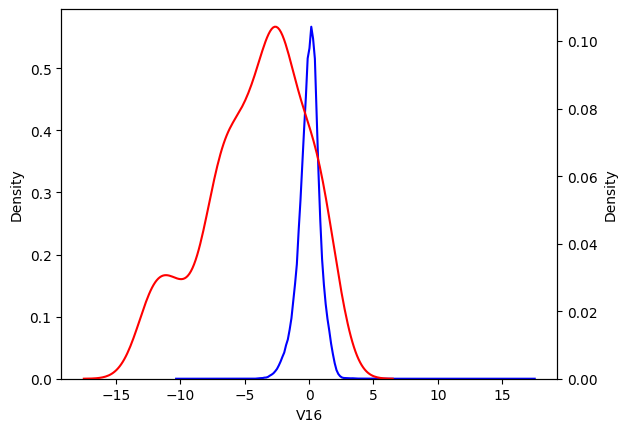

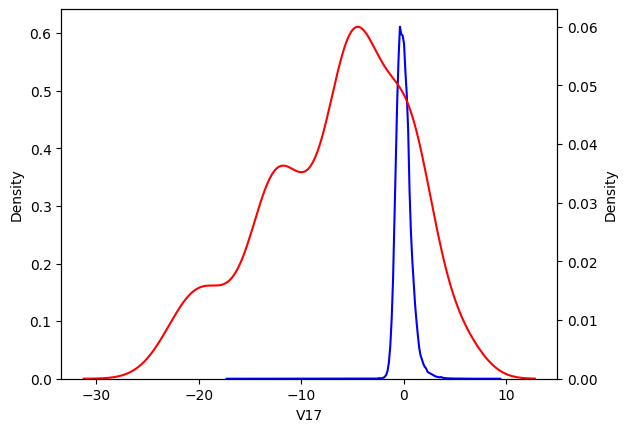

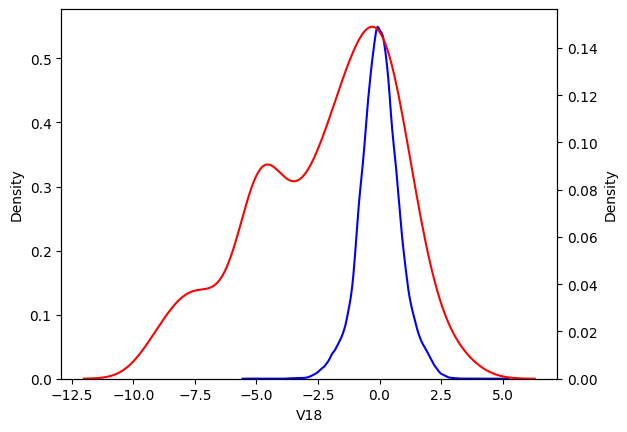

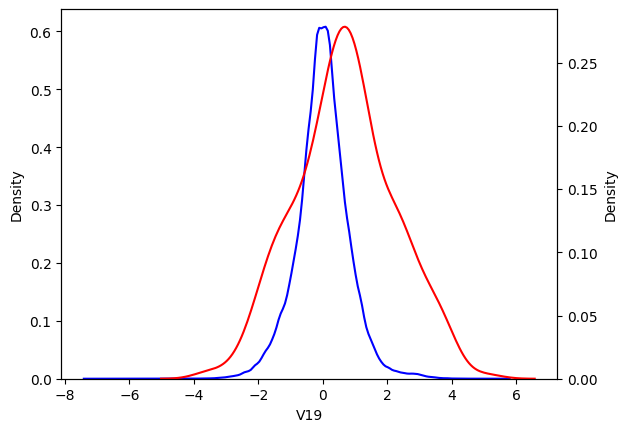

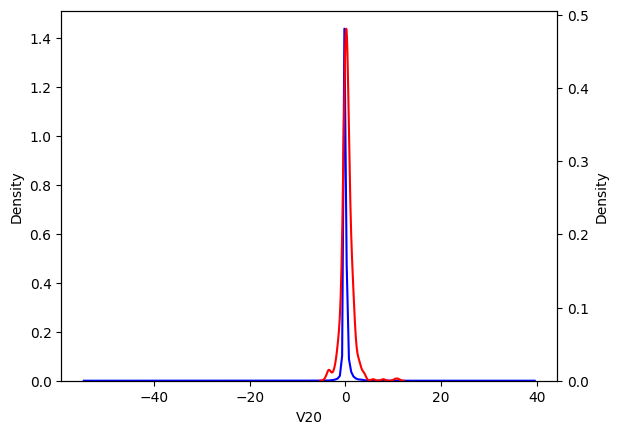

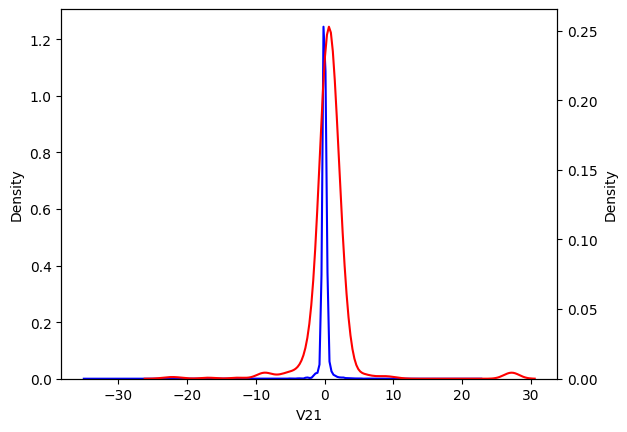

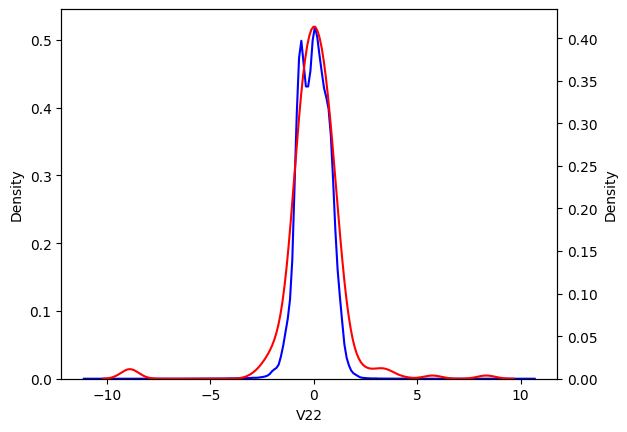

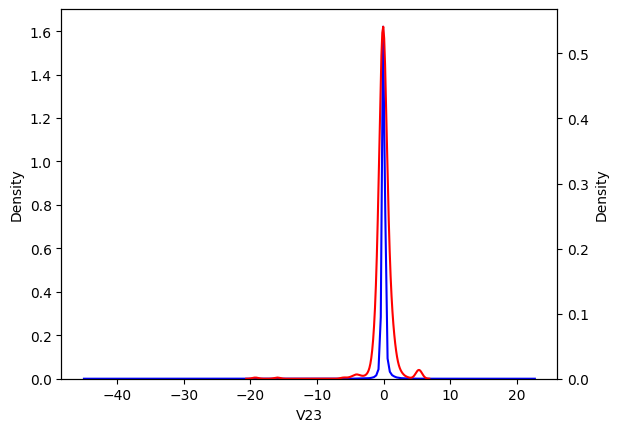

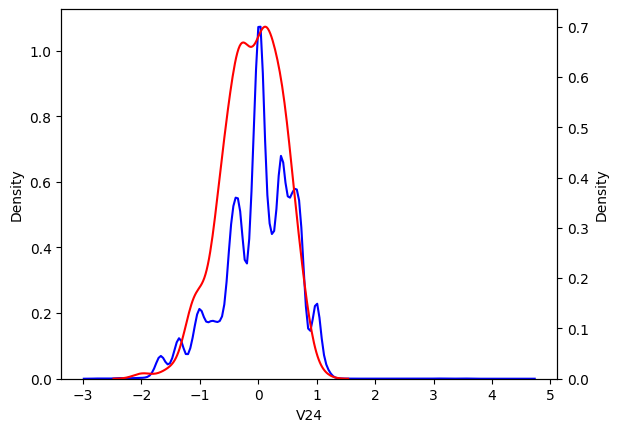

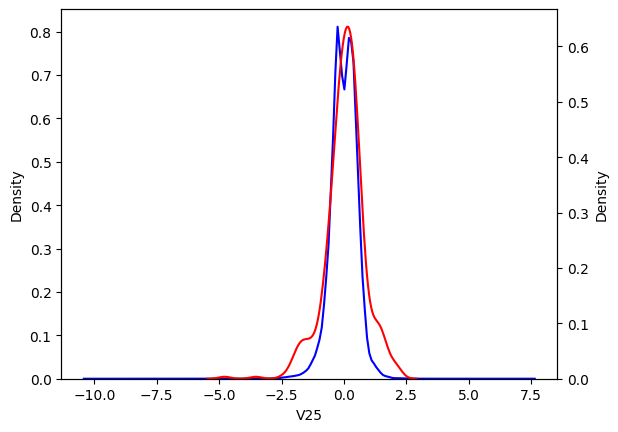

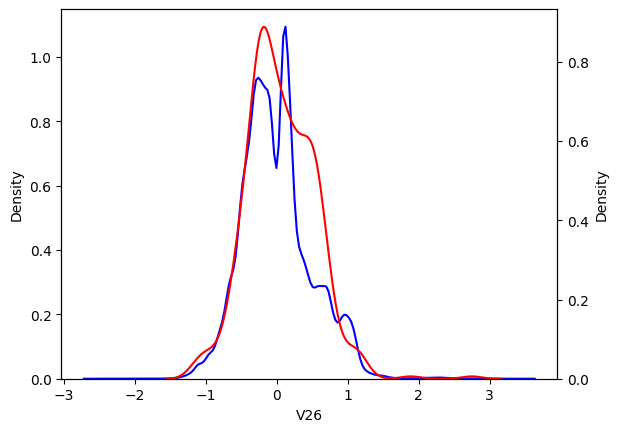

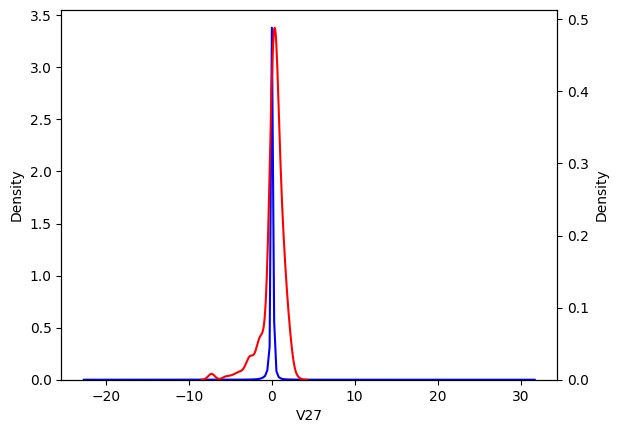

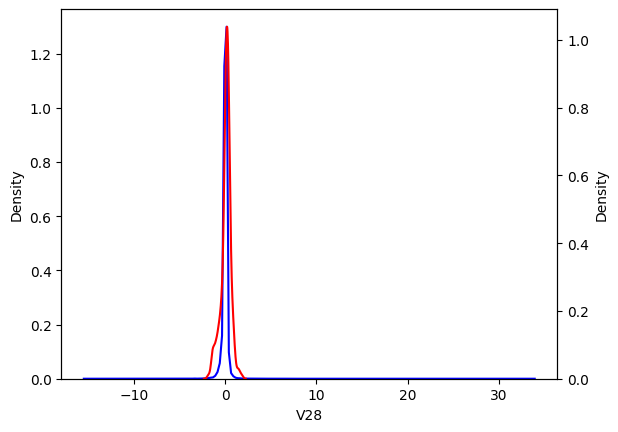

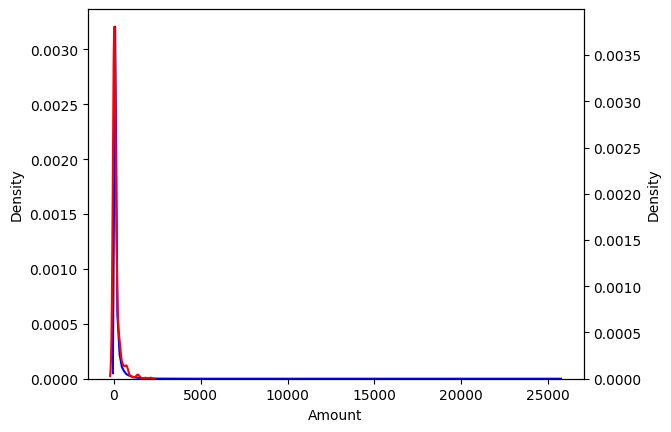

In [5]:
#Plot Each Column as KDE Plot, split by class
for i in range(30):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sns.kdeplot(ax=ax1, data=data[data["Class"]==0].iloc[:,i], color='blue')
    sns.kdeplot(ax=ax2, data=data[data["Class"]==1].iloc[:,i], color='red')
    plt.show()

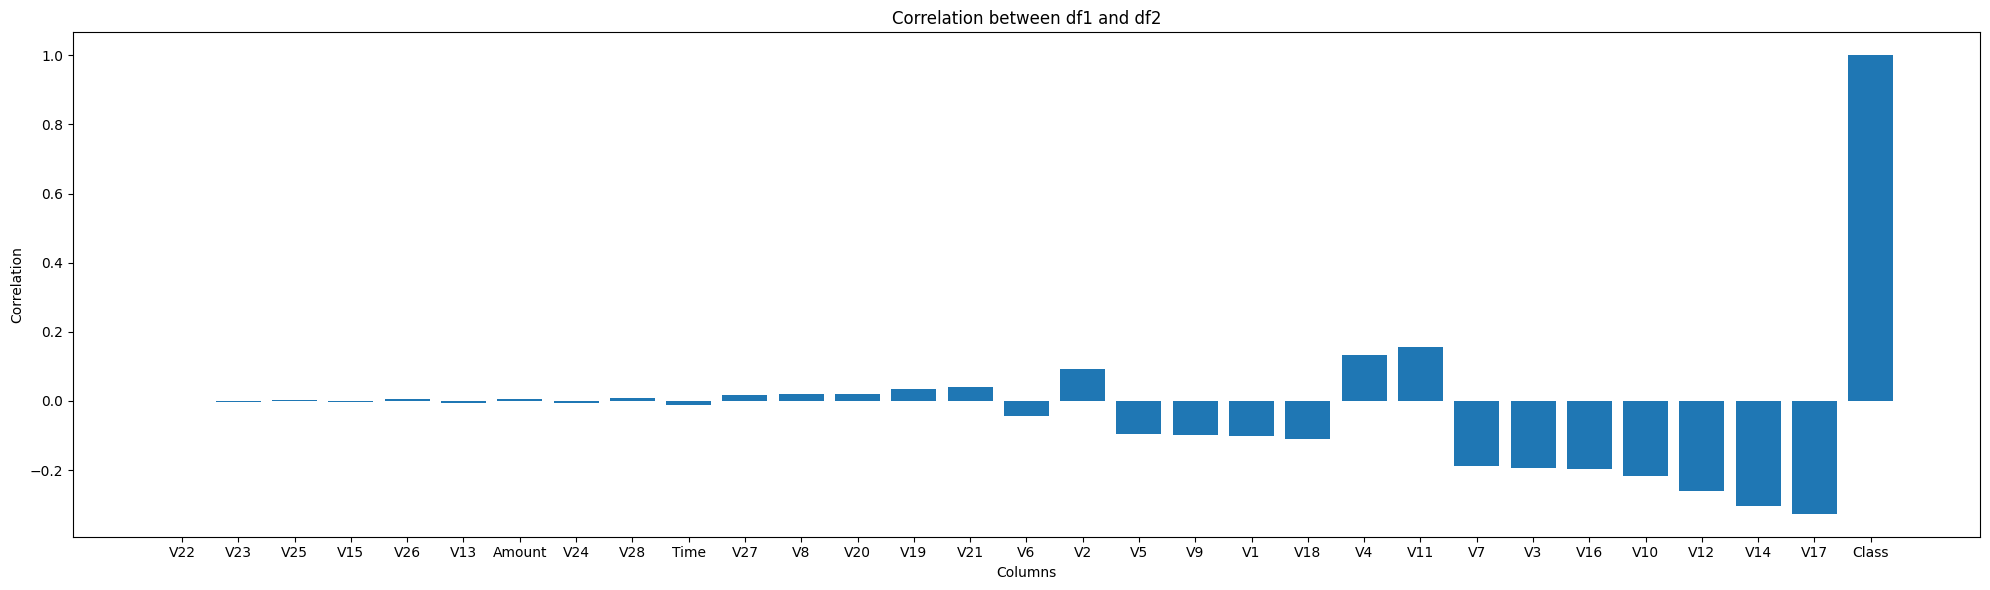

In [6]:
#Plot correlations with Class fields
correlations = data.corrwith(data['Class'])
correlations.sort_values(key=abs, inplace=True)

plt.figure(figsize=(20, 6))
plt.bar(correlations.index, correlations.values)
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.title('Correlation between df1 and df2')
plt.tight_layout()
plt.show()

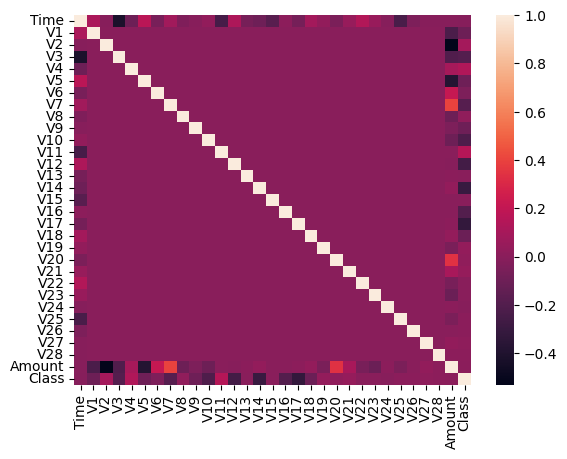

In [7]:
corelation_values = data.corr()

corr_heatmap = sns.heatmap(corelation_values, xticklabels=data.columns, yticklabels=data.columns)

In [8]:
data.drop(['V22', 'V23', 'V25', 'V15', 'V26', 'V13', 'V24'], axis=1, inplace=True)

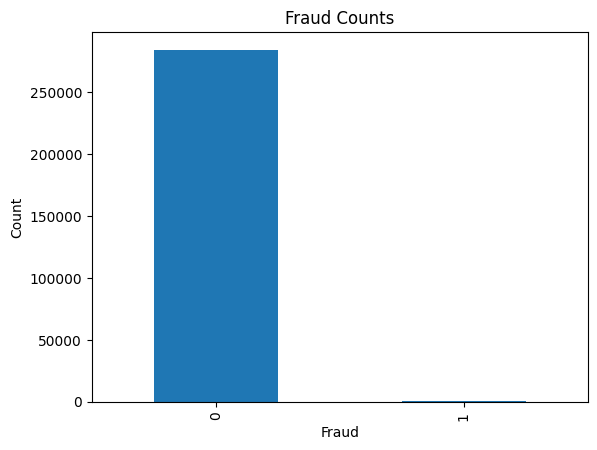

Count of non-fraud cases: 284315
Count of fraud cases: 492


In [9]:
#Visualize disparity in data
counts = data['Class'].value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of fraud cases: "+str(counts[1]))

In [10]:
y = data["Class"]
X = data.drop(['Class'], axis=1)

In [11]:
#Split data into train, test, and val in two split steps
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val)
print("Original X Shape: "+str(X.shape))
print("Original y Shape: "+str(y.shape))
print("Train X Shapes: "+str(X_train.shape))
print("Train y Shape: "+str(y_train.shape))
print("Validate X Shapes: "+str(X_test.shape))
print("Validate y Shape: "+str(y_test.shape))
print("Test X Shapes: "+str(X_val.shape))
print("Test y Shape: "+str(y_val.shape))

Original X Shape: (284807, 23)
Original y Shape: (284807,)
Train X Shapes: (199364, 23)
Train y Shape: (199364,)
Validate X Shapes: (42721, 23)
Validate y Shape: (42721,)
Test X Shapes: (42722, 23)
Test y Shape: (42722,)


In [12]:
#Rescale all columns
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [13]:
#Apply fitted transformer to test columns
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_val[X_val.columns] = scaler.transform(X_val[X_val.columns])

### Model Architecture

We start with a very basic model that takes an input layer of the size of our vectors, and uses Dense - Leaky ReLU layers with a BatchNormalization layer to again ensure that gradients do not explode or vanish, and a Dropout layer to combat overfitting.

First, we run this model on the unbalanced dataset just to demonstrate the issues with using the unbalanced dataset. The baseline model significantly underpredicts the fraud cases as is expected, so for the rest of this project we will be looking at two options for improving this poor fit due to unbalanced data.

In [14]:
def build_discriminator():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(23,)))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.5))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    return model

In [15]:
solo_discriminator = build_discriminator()

I0000 00:00:1728985600.822472 2451237 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 05:46:40.822815: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
solo_discriminator.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

solo_discriminator.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/5
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 4s 459us/step - accuracy: 0.9848 - loss: 0.0452 - val_accuracy: 0.9992 - val_loss: 0.0073
Epoch 2/5
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9993 - val_loss: 0.0042
Epoch 3/5
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 3s 463us/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9993 - val_loss: 0.0064
Epoch 4/5
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 3s 448us/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0053
Epoch 5/5
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 3s 452us/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0061


In [138]:
predictions = solo_discriminator.predict(X_val)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = pd.DataFrame(predicted_classes)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


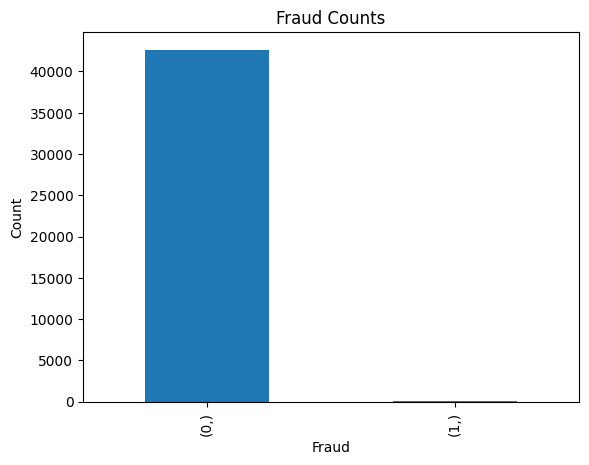

Count of non-fraud cases: 42643
Count of non-fraud cases: 79


In [139]:
counts = predicted_classes.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of non-fraud cases: "+str(counts[1]))

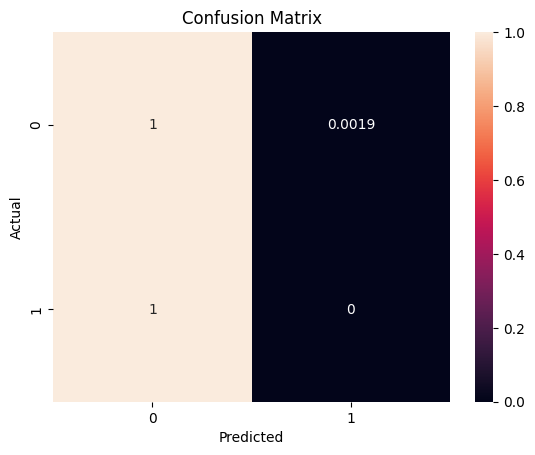

In [142]:
cm = confusion_matrix(y_test, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model Architecture Continued

In order to improve our model, we first oversample our data with the same model as in the previous run, so that we have balanced classes. Oversampling simply duplicates entries of the dataset until the classes are balanced, so this does not add new information but it does ensure that the model is more harshly penalized for favoring non-fraud cases due to the dataset balance.

Observe that this gives a major improvement over the previous model, capturing 84% of fraud cases with a very low false positive rate of less than 1%. 

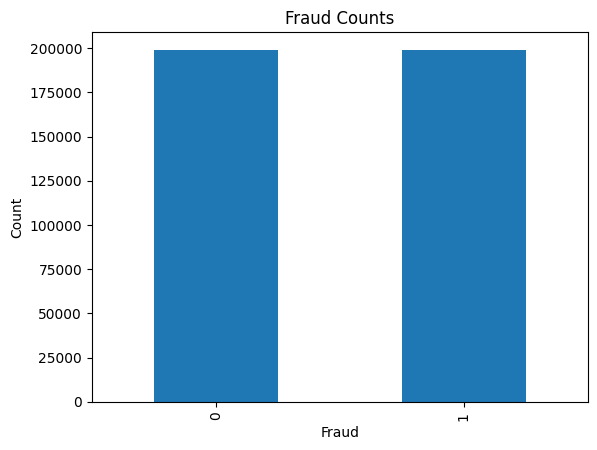

Count of non-fraud cases: 199020
Count of fraud cases: 199020


In [19]:
train_oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = train_oversampler.fit_resample(X_train, y_train)

counts = y_train_resampled.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of fraud cases: "+str(counts[1]))

In [20]:
solo_discriminator_resampled = build_discriminator()

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [21]:
solo_discriminator_resampled.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

solo_discriminator_resampled_history = solo_discriminator_resampled.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/5
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 6s 422us/step - accuracy: 0.9565 - loss: 0.1139 - val_accuracy: 0.9861 - val_loss: 0.0514
Epoch 2/5
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 431us/step - accuracy: 0.9861 - loss: 0.0396 - val_accuracy: 0.9912 - val_loss: 0.0356
Epoch 3/5
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 434us/step - accuracy: 0.9902 - loss: 0.0293 - val_accuracy: 0.9898 - val_loss: 0.0344
Epoch 4/5
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 431us/step - accuracy: 0.9913 - loss: 0.0275 - val_accuracy: 0.9948 - val_loss: 0.0262
Epoch 5/5
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 427us/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.9896 - val_loss: 0.0371


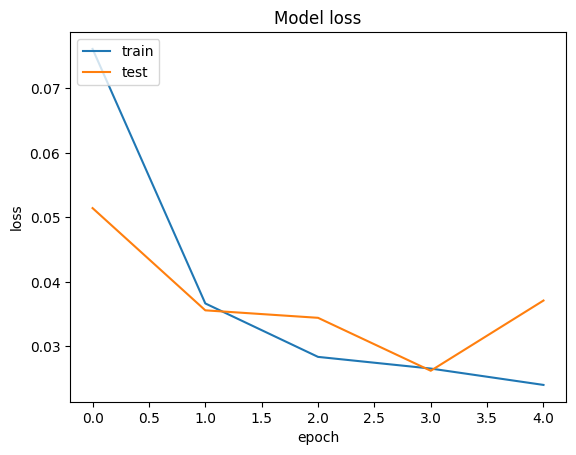

In [22]:
plt.plot(solo_discriminator_resampled_history.history['loss'])
plt.plot(solo_discriminator_resampled_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

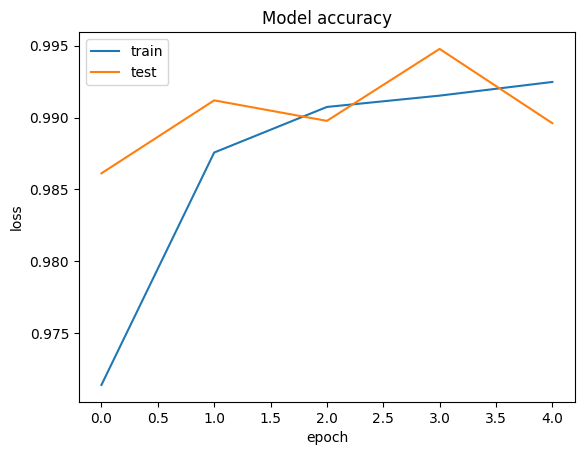

In [23]:
plt.plot(solo_discriminator_resampled_history.history['accuracy'])
plt.plot(solo_discriminator_resampled_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
predictions = solo_discriminator_resampled.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = pd.DataFrame(predicted_classes)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


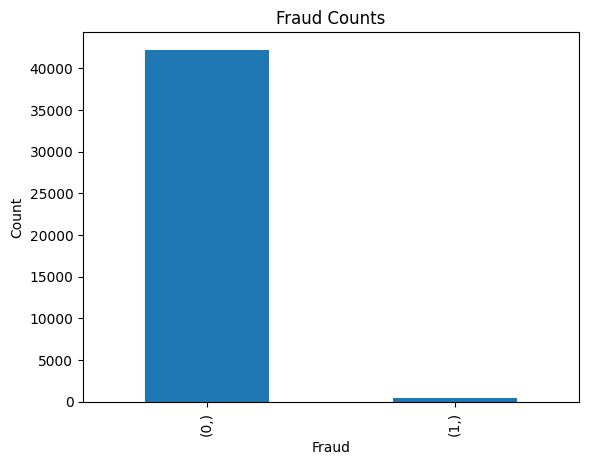

Count of non-fraud cases: 42235
Count of fraud cases: 486


In [25]:
counts = predicted_classes.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of fraud cases: "+str(counts[1]))

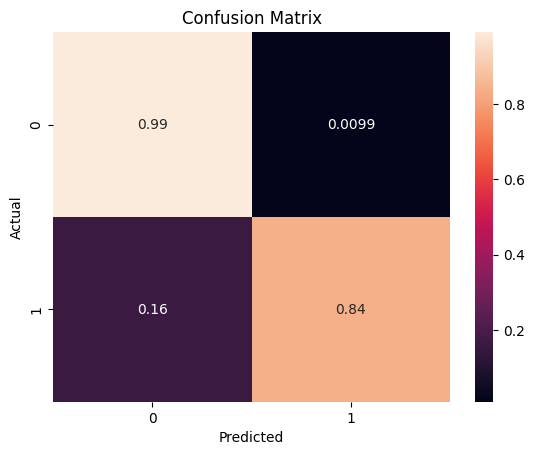

In [26]:
cm = confusion_matrix(y_test, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model Architecture Continued

While the previous model worked well, we are still just duplicating the data that was already provided when oversampling. As an alternative we can try to generate fraudulent transactions of our own to train the generator on.

To do this, we create a new generator model that takes random noise and builds a "transaction" by providing entries for each of the expected 23 input fields. We then build an adversarial model that merges a set of generated transactions with a set of legitimate transactions, so instead of training off of the small dataset of real fraud events, the new discriminator instance trains to distinguish legitimate transactions from artificially generated ones.

Testing this model we observe one of the disadvantages of adversarial models however, if either the generator or the discriminator trains too quickly it outpaces the other model which stops getting meaningful data.

Imagine a perfect discriminator that always discerns the difference between a generated transaction and a legitimate one. Since it always predicts a 0 on generated events the generator would only know that all outputs are equally wrong, so it cannot improve, therefore the discriminator never gets a challenge either and it cannot train.

We see this happen in this model, with our discriminator loss vanishing while the generator loss explodes, which means that when we introduce the discriminator to actual fraud data it is not calibrated to handle it predicts fraud for almost all cases and is extremely inaccurate.

In [27]:
def build_generator():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Dense(16))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Dense(23, activation='tanh'))

    return model

In [28]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):

        batch_size = tf.shape(data)[0]
        
        noise = tf.random.normal(shape=(batch_size, 8))
        generator_preds = self.generator(noise)

        discriminator_x = tf.concat([generator_preds, data], axis=0)

        discriminator_y = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        with tf.GradientTape() as tape:
            discriminator_preds = self.discriminator(discriminator_x)
            d_loss = self.loss_fn(discriminator_y, discriminator_preds)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

        noise = tf.random.normal(shape=(batch_size, 8))
        generated_labels = tf.ones((batch_size, 1))
            
        with tf.GradientTape() as tape:
            generated_preds = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(generated_labels, generated_preds)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )
            
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [29]:
test_discriminator = build_discriminator()
test_generator = build_generator()
test_gan = GAN(test_discriminator, test_generator)
test_gan.compile(keras.optimizers.Adam(learning_rate=0.001), 
            keras.optimizers.Adam(learning_rate=0.001),
            keras.losses.BinaryCrossentropy())

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [30]:
fraud_indices = y_train[y_train == 1]
X_train_no_fraud = X_train.drop(fraud_indices.index)

In [31]:
X_train_no_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V14,V16,V17,V18,V19,V20,V21,V27,V28,Amount
244376,1.207222,1.079980,0.139881,-1.260809,0.195445,0.568619,-0.405142,0.202330,-0.230167,0.317882,...,-1.166464,0.478502,0.245475,-0.333872,0.305481,-0.076386,-0.533893,-0.137332,-0.100873,-0.342258
37292,-1.181507,-0.322206,0.734072,0.918614,0.106064,-0.246285,-1.002122,0.516828,-0.040775,-0.094152,...,-0.302162,0.285679,0.289319,-0.262075,-0.387994,0.221833,-0.370655,0.850730,0.518427,-0.321865
188365,0.693680,-3.600080,-4.081600,-3.369839,-0.069302,1.082282,-0.928528,-0.835611,-4.733915,-1.488302,...,1.986145,2.077108,0.107584,-1.028042,0.223626,-0.693535,-3.469049,6.046743,-8.027653,0.833278
30917,-1.239587,-0.986226,0.490506,0.845627,0.838454,0.242308,-0.268760,0.087191,0.427177,-1.074869,...,0.933099,-0.383016,0.287075,-0.526527,1.072481,-0.102226,-0.473075,0.308010,-0.433812,-0.227789
101353,-0.572695,-0.422989,-0.197930,1.922401,-1.121007,-0.807795,0.841760,-0.798837,0.635797,0.119634,...,-1.127701,0.877014,0.789165,-1.131647,0.648634,0.088375,0.250239,0.863225,0.337799,-0.346124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56508,-1.001138,0.663918,0.281645,-0.010740,0.640501,0.210305,-0.338689,0.259761,-0.242262,-0.212095,...,-0.019583,0.238610,-0.981785,-0.121166,-0.084860,0.006672,-0.004916,0.058738,0.050907,-0.321589
132781,-0.313587,0.618704,-0.037138,0.618424,0.810405,-0.422102,0.201878,-0.470608,0.124377,0.878445,...,-0.407588,0.373093,-0.643687,0.262590,0.127129,-0.143058,-0.161755,0.173964,0.092377,-0.310663
206190,0.865584,0.970162,-1.351235,0.252053,-0.798379,-1.687970,0.297176,-1.578836,0.190062,-0.297200,...,-1.430657,-0.700605,0.757774,0.358872,0.310498,-0.204229,-0.120031,0.177194,-0.053934,0.182990
179414,0.612119,-5.155469,-0.322357,-3.059037,-1.846036,0.122460,1.010758,-0.330374,-9.813358,4.133540,...,-0.922975,-0.073794,-1.246813,0.178629,1.241120,-4.781536,5.461075,-3.209445,10.756653,0.209024


In [32]:
test_gan_history = test_gan.fit(X_train_no_fraud, epochs=5)

Epoch 1/5
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 5s 588us/step - d_loss: 0.1807 - g_loss: 3.2449
Epoch 2/5
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 546us/step - d_loss: 0.1211 - g_loss: 3.8191
Epoch 3/5
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step - d_loss: 7.8988e-04 - g_loss: 11.9457
Epoch 4/5
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step - d_loss: 4.0208e-04 - g_loss: 13.7767
Epoch 5/5
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 576us/step - d_loss: 0.0094 - g_loss: 15.5442


In [33]:
predictions = test_discriminator.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = pd.DataFrame(predicted_classes)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


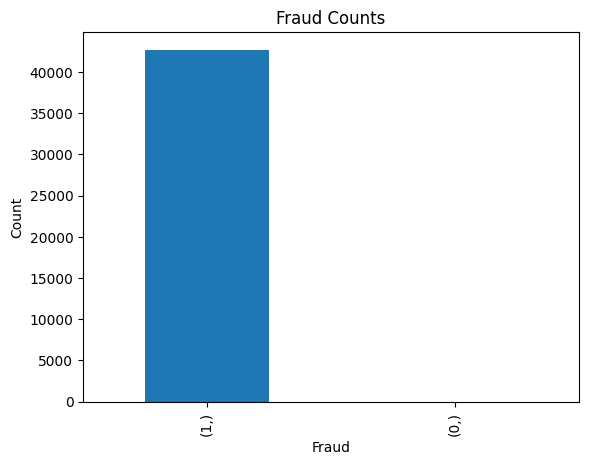

Count of fraud cases: 42717


In [34]:
counts = predicted_classes.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of fraud cases: "+str(counts[1]))

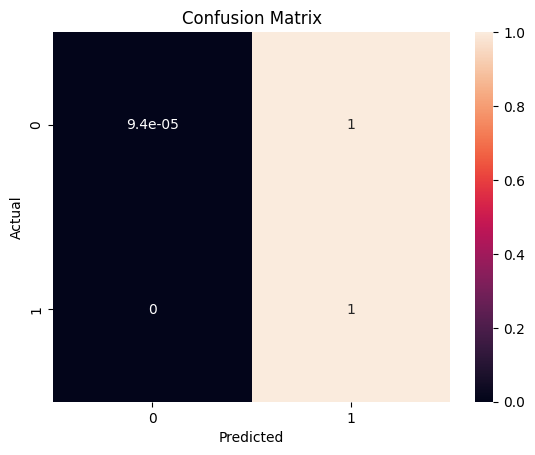

In [35]:
cm = confusion_matrix(y_test, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model Architecture Continued

To try to prevent the adversarial network from collapsing, we implement a check between the loss of the discriminator and the generator in each batch, and don't update the weights of the "winning" model. Our hope is that this change will allow the models to remain more consistent, and for one to catch up if the other gets substantially ahead instead of the entire adversarial network collapsing as above.

Running this model we see that it appears to be successful at least in preventing the collapse. Where in the previous model we saw the generator loss increase rapidly in each epoch, here the generator and the discriminator losses remain relatively constant, and if anything both decline over 20 epochs.

Producing our confusion matrix on the predictions we see that our performance has improved massively, capturing 91% of fraud instances, and only falsely predicting 25% of non-fraud transactions.

In [36]:
class StabilizedGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.is_first_run = True

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.fraud_loss_fn = keras.losses.CosineSimilarity()

    @tf.function
    def train_step(self, data):

        batch_size = tf.shape(data)[0]
        
        noise = tf.random.normal(shape=(batch_size, 8))
        generator_preds = self.generator(noise)

        discriminator_x = tf.concat([generator_preds, data], axis=0)

        discriminator_y = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        with tf.GradientTape(persistent = True) as tape:
            noise = tf.random.normal(shape=(batch_size, 8))
            generated_labels = tf.ones((batch_size, 1))
            discriminator_preds = self.discriminator(discriminator_x)
            d_loss = self.loss_fn(discriminator_y, discriminator_preds)
            generated_preds = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(generated_labels, generated_preds)

            if tf.math.greater(d_loss, g_loss):
                grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
                self.d_optimizer.apply_gradients(
                    zip(grads, self.discriminator.trainable_weights)
                )
            if not tf.math.greater(d_loss, g_loss):
                grads = tape.gradient(g_loss, self.generator.trainable_weights)
                self.g_optimizer.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
            
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [37]:
stabilized_discriminator = build_discriminator()
stabilized_generator = build_generator()
stabilized_gan = StabilizedGAN(test_discriminator, test_generator)
stabilized_gan.compile(keras.optimizers.Adam(learning_rate=0.002), 
            keras.optimizers.Adam(learning_rate=0.002),
            keras.losses.BinaryCrossentropy())

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [38]:
stabilized_gan_history = stabilized_gan.fit(X_train_no_fraud, epochs=20)

Epoch 1/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 5s 519us/step - d_loss: 0.6935 - g_loss: 3.9025
Epoch 2/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 538us/step - d_loss: 1.1086 - g_loss: 9.4396
Epoch 3/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 525us/step - d_loss: 1.5220 - g_loss: 8.4036
Epoch 4/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step - d_loss: 1.9188 - g_loss: 5.6620
Epoch 5/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 524us/step - d_loss: 1.9719 - g_loss: 5.4988
Epoch 6/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - d_loss: 1.7558 - g_loss: 5.0500
Epoch 7/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 519us/step - d_loss: 1.4501 - g_loss: 6.2879
Epoch 8/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 522us/step - d_loss: 1.4475 - g_loss: 6.2879
Epoch 9/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 565us/step - d_loss: 1.4529 - g_loss: 6.2879
Epoch 10/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 525us/step - d_loss: 1.4455 - g_loss: 6.2879
Epoch 11/20
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step - d_loss: 1.4535 - g_loss: 6.2879
Epoch 12

In [134]:
predictions = stabilized_discriminator.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = pd.DataFrame(predicted_classes)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


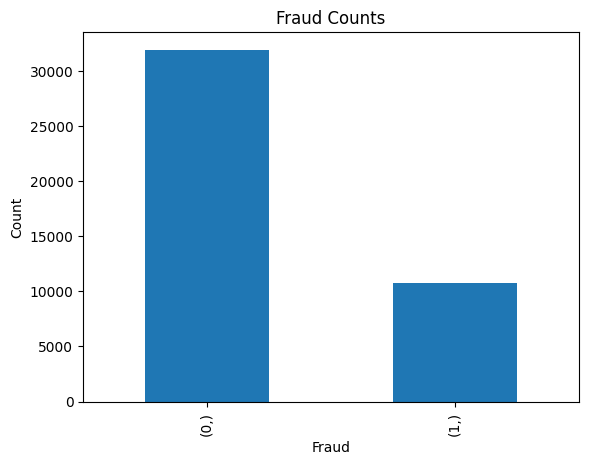

Count of non-fraud cases: 31927
Count of fraud cases: 10794


In [135]:
counts = predicted_classes.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of fraud cases: "+str(counts[1]))

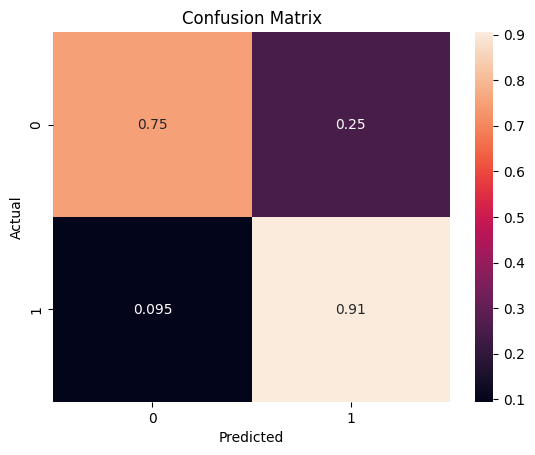

In [136]:
cm = confusion_matrix(y_test, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Results and Analysis

As our last model we take our original discriminator and give it hyperparameter fields to use with the Keras tuner. This allows us to test many of the baseline assumptions we used for the original model and determine the values that are actually preferable.

After running hyperparameter tuning using our validation data we can obtain the best set of hyperparameters and retrain the model using those.

This appears to give us a much smoother loss and accuracy curve with less indication of overfitting, as we do not see the validation data diverge from the training data as much as in the first test, likely to do with the learning rate hyperparameter. Additionally the final trained model has slightly better performance than the first iteration, capturing 93% of fraud cases, up from 87%.

In [42]:
def build_tuned_discriminator(params):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(23,)))
    model.add(keras.layers.Dense(params.Int("dense_size_1", min_value=16, max_value=128, step=16)))
    model.add(keras.layers.LeakyReLU(alpha=params.Float("alpha_1", min_value=0.1, max_value=0.9, step=0.1)))
    model.add(keras.layers.BatchNormalization(momentum=params.Float("momentum", min_value=0.1, max_value=0.9, step=0.1)))
    model.add(keras.layers.Dropout(params.Float("dropout", min_value=0.1, max_value=0.9, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_2", min_value=16, max_value=128, step=16)))
    model.add(keras.layers.LeakyReLU(alpha=params.Float("alpha_2", min_value=0.1, max_value=0.9, step=0.1)))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=params.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [43]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_tuned_discriminator,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="cancer_detection",
)

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [44]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dense_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
alpha_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
momentum (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
dense_size_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
alpha_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [58]:
tuner.search(X_train_resampled, y_train_resampled, epochs=2, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.9778334200382233

Best val_accuracy So Far: 0.9965825378894806
Total elapsed time: 00h 05m 24s


In [59]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/midelan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,705 (18.38 KB)

 Non-trainable params: 160 (640.00 B)

In [93]:
best_hps = tuner.get_best_hyperparameters(1)
final_model = build_tuned_discriminator(best_hps[0])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

final_model_history = final_model.fit(X_train_resampled, y_train_resampled, 
                                validation_data = (X_val, y_val),
                                epochs = 10,
                                verbose = 1,
                                callbacks=[callback])

Epoch 1/10


/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12439/12439 ━━━━━━━━━━━━━━━━━━━━ 6s 444us/step - accuracy: 0.9669 - loss: 0.0914 - val_accuracy: 0.9909 - val_loss: 0.0323
Epoch 2/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 430us/step - accuracy: 0.9941 - loss: 0.0192 - val_accuracy: 0.9937 - val_loss: 0.0234
Epoch 3/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 435us/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9975 - val_loss: 0.0127
Epoch 4/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 436us/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9979 - val_loss: 0.0134
Epoch 5/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 437us/step - accuracy: 0.9976 - loss: 0.0093 - val_accuracy: 0.9968 - val_loss: 0.0135
Epoch 6/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 435us/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9984 - val_loss: 0.0100
Epoch 7/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 435us/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.9973 - val_loss: 0.0138
Epoch 8/10
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 5s 436us/step - accuracy: 0.9

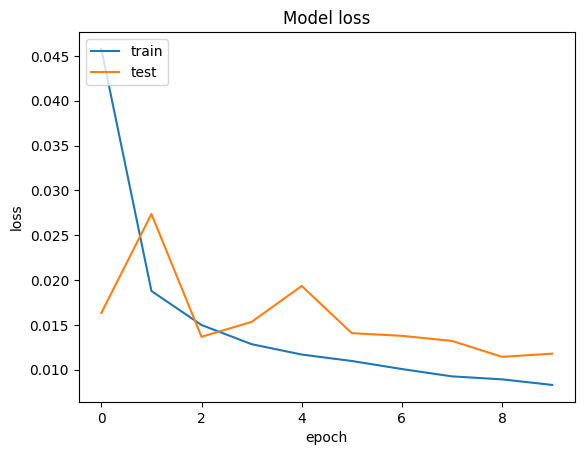

In [108]:
plt.plot(final_model_history.history['loss'])
plt.plot(final_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

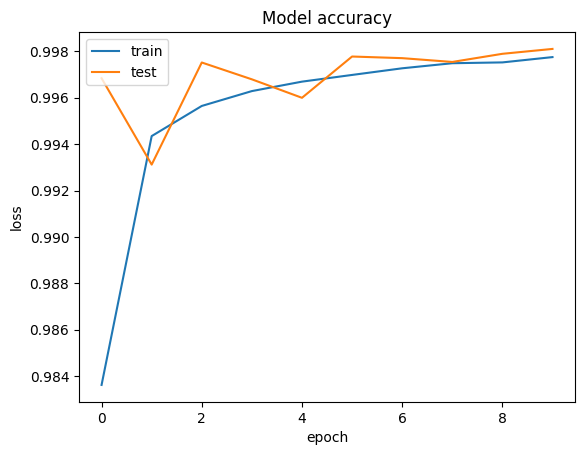

In [109]:
plt.plot(final_model_history.history['accuracy'])
plt.plot(final_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [104]:
predictions = final_model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = pd.DataFrame(predicted_classes)

1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


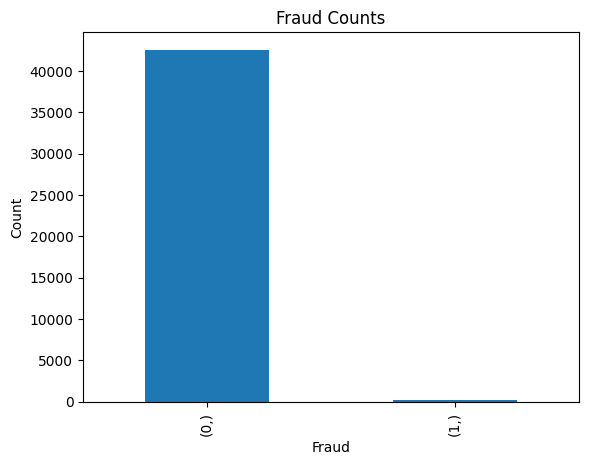

Count of non-fraud cases: 42587
Count of fraud cases: 134


In [105]:
counts = predicted_classes.value_counts()

counts.plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Fraud Counts')
plt.show()

print("Count of non-fraud cases: "+str(counts[0]))
print("Count of fraud cases: "+str(counts[1]))

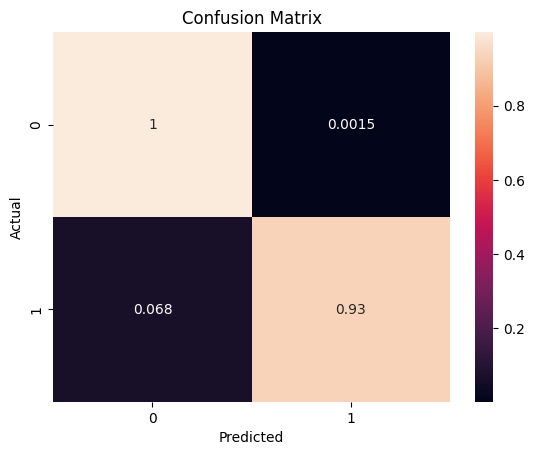

In [106]:
cm = confusion_matrix(y_test, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Conclusion

We have demonstrated two potential mdels for detecting credit card fraud in a highly unbalanced dataset, an oversampled neural network and an adversarial neural network.

The oversampled neural network is the classical solution to this problem of unbalanced data and it certainly works in this case. It is possible that we could extend the number of trainable features or provide further training, but the already high level of accuracy is very promising for this approach. Perhaps the biggest improvement here would be dependent on a better dataset. We know that there are many cases of very different types of fraud going on, and modern banks collect massive amounts of information, but due to privacy concerns we do not have access to it. Perhaps a data sharing arrangement of anonimized fraud cases where the columns are known but any personally identifying data is mocked would allow more widespread access to more fraud cases for model training.

For the generative approach with an adversarial network, it would not be a viable solution at this time. The problem is very well suited to standard neural networks and whatever benefits are seen in generating fake transactions from noise they are overshadowed by the 25% fraud detection rate on non-fraudulent data. With such an unbalanced dataset this would be an impossible amount of transactions to send for manual review, so the model is not ready to be used in the real world at the moment. Additionally, the model subjectively appeared to still get stuck in local equilibriums while we were testing some different parameters, with some seeds training well and others stopping after a number of epochs.

In spite of these shortcomings, we think this approach could be interesting to look into incorporating into other adversarial networks, since it clearly did prevent the losses from exploding. With further fine tuning or the right problem space this approach could potentially be viable. Of particular interest would be feeding fraudulent data into the model and adding a loss term for how far the generated examples fall from real fraud cases. This could produce an interesting balancing act where the generator can innovate on existing frauds, but is constrained away from just mimicking real transactions.

## References:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

https://www.bankrate.com/credit-cards/news/credit-card-fraud-statistics/?tpt=a